<a href="https://colab.research.google.com/github/Mattliketocode/fuzzy-octo-tribble/blob/main/MACS_CAP_5625_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elastic Net for Credit Card Balance Prediction


---

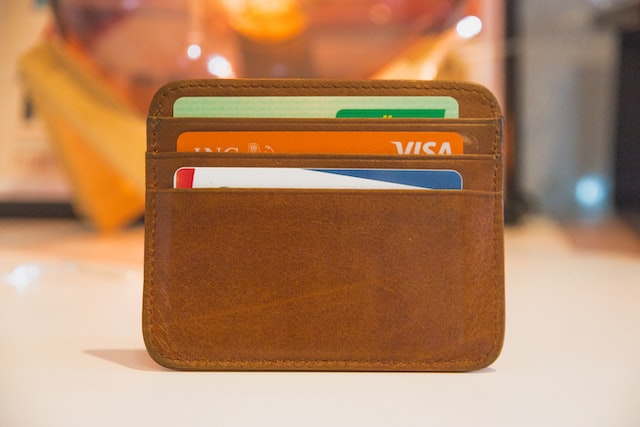

*Given information about a person, can we
predict their credit card balance using elastic net?*

---

Created by Matthew Acs

This project explores the development of an elastic net model to predict credit card balance based on nine features. The model will be developed both from scratch and using Sklearn.

*Note: I use the terms weights and model parameters interchangeable to signify the same thing. That is, they mean the model parameters that are obtained via training the regression model.*

## Data


---


The first step is to prepare the data for the model. This is done by importing the data, exploring it, processing it, splitting it into datasets, and standardizing it.

### Imports and Data Upload


---



The code below imports the necessary dependencies and uploads the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from prettytable import PrettyTable

url = 'https://raw.githubusercontent.com/Mattliketocode/fuzzy-octo-tribble/main/Credit_N400_p9.csv'
data_import = pd.read_csv(url)

### Data Exploration


---



The following two code cells explore the data. This is important to understand the type of data that is being used and the range of values that are present. From the data exploration we can see that gender, student, and married must be encoded for the regression model because they are currently strings rather than binary values.

In [ ]:
data_import.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580
3,148.924,9504,681,3,36,11,Female,No,No,964
4,55.882,4897,357,2,68,16,Male,No,Yes,331


In [ ]:
data_import.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


### Data Preprocessing


---



The code below processes the discrete features by converting them to a binary encoding scheme.

In [ ]:
data = data_import.to_numpy()

for x in data:

  ## Male is encoded by 0, Female by 1
  if x[6] == 'Male':
    x[6] = 0
  else:
    x[6] = 1

  ## No is encoded by 0, Yes by 1
  if x[7] == 'No':
    x[7] = 0
  else:
    x[7] = 1

  ## No is encoded by 0, Yes by 1
  if x[8] == 'No':
    x[8] = 0
  else:
    x[8] = 1

data = np.array(data, dtype='float')

### Dataset standardization and preparation


---



The next step is to split and standardize the data. The dataset is split into a set containing all 400 data entries and five datasets for five fold cross validation. Each of these datasets are then standardized. This is done by subtracting the mean from each feature and dividing by the standard deviation. The output is also centered by subtracting the mean. The validation datasets are standardized according to their respective training dataset standardization parameters in order to retain the correct scale for the data.

In [ ]:
def standardize(data, val_data = []):
  if len(val_data) == 0:
    means = np.mean(data, 0)
    stdev = np.std(data, 0)
    stdev[stdev.size-1] = 1
    std_data = (data-means)/stdev
    return std_data
  else:
    means = np.mean(data, 0)
    stdev = np.std(data, 0)
    stdev[stdev.size-1] = 1
    std_data = (val_data-means)/stdev
    return std_data

In [ ]:
train_splits = {}
for i in range(5):
  train_splits[i] = []

val_splits = {}
for i in range(5):
  val_splits[i] = []

for i in range(5):
  for j in range(400):
    if (j < i*80) or (j >= (i+1) * 80):
      train_splits[i].append(data[j])
    else:
      val_splits[i].append(data[j])

for i in range(5):
  train_splits[i] = np.array(train_splits[i])
  val_splits[i] = np.array(val_splits[i])

X_train = {}
y_train = {}
for i in range(5):
  X_train[i] = standardize(train_splits[i][:, 0:9])
  y_train[i] = standardize(train_splits[i][:, 9:10])

X_val = {}
y_val = {}
for i in range(5):
  X_val[i] = standardize(train_splits[i][:, 0:9], val_splits[i][:, 0:9])
  y_val[i] = standardize(train_splits[i][:, 9:10], val_splits[i][:, 9:10])

X_full = standardize(data[:, 0:9])
y_full = standardize(data[:, 9:10])

## Regression from Scratch



---



Now that the data is prepared, elastic net regression will be implemented from scratch.

### Elastic Net Regression Algorithm


---



The code below defines an elastic net regression function that takes a feature selection parameter alpha, constraint parameter lmbda, and the data. It returns the trained model parameters.

In [ ]:
def elastic_net(alpha, lmbda, X, y):
  np.random.seed(1)
  B = np.random.rand(9,1)

  bk = [0,0,0,0,0,0,0,0,0]
  for x in range(9):
    sum = 0
    for i in range(len(y)):
      sum = sum + (X[i][x] ** 2)
    bk[x] = sum

  ak = [0,0,0,0,0,0,0,0,0]
  for i in range(1000):
    for x in range(9):
      ak[x] = (np.dot((np.transpose((X[: , x : (x+1)]))), np.reshape((y - np.dot(X, B)), len(y)) + np.dot((X[: , x : (x+1)]), B[x])))
      placeholder = (np.absolute(ak[x]) - (lmbda * (1-alpha))/2)
      if placeholder < 0:
        placeholder = 0
      B[x] = (np.sign(ak[x]) * placeholder) / (bk[x] + lmbda*alpha)
  
  return B

### Full Dataset Training



---



The code below trains nine models based on lambda parameters from 0.01 to 1000000 and alpha parameters from 0 to 1 in increments of 1/5. The parameters for each feature are then graphed to show the impact of the lambda parameter for each alpha value. As the parameter increases, the model becomes more constrained and the parameters tend to zero to minimize the penalized cost function. The graphs also show how the alpha value influences the ridge/lasso characteristics of the model.

In [ ]:
weights_a1 = {}
alpha = 0
for i in range(9):
    weights_a1[i] = elastic_net(alpha, 0.01 * (10**i), X_full, y_full)

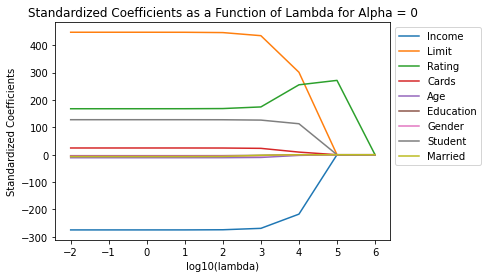

In [ ]:
features = {}
for i in range(9):
    features[i] = []

for i in range(9):
  for j in range(9):
    features[i].append(weights_a1[j][i])

for i in range(9):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], features[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
weights_a2 = {}
alpha = 0.2
for i in range(9):
    weights_a2[i] = elastic_net(alpha, 0.01 * (10**i), X_full, y_full)

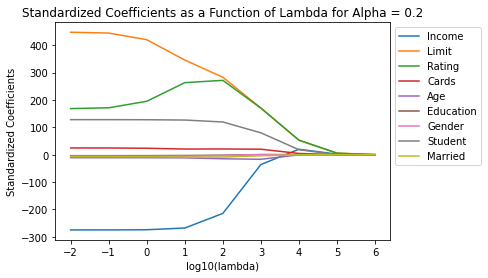

In [ ]:
features = {}
for i in range(9):
    features[i] = []

for i in range(9):
  for j in range(9):
    features[i].append(weights_a2[j][i])

for i in range(9):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0.2")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], features[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
weights_a3 = {}
alpha = 0.4
for i in range(9):
    weights_a3[i] = elastic_net(alpha, 0.01 * (10**i), X_full, y_full)

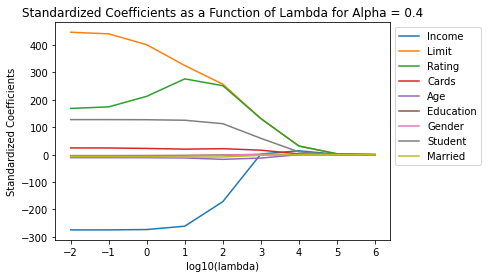

In [ ]:
features = {}
for i in range(9):
    features[i] = []

for i in range(9):
  for j in range(9):
    features[i].append(weights_a3[j][i])

for i in range(9):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0.4")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], features[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
weights_a4 = {}
alpha = 0.6
for i in range(9):
    weights_a4[i] = elastic_net(alpha, 0.01 * (10**i), X_full, y_full)

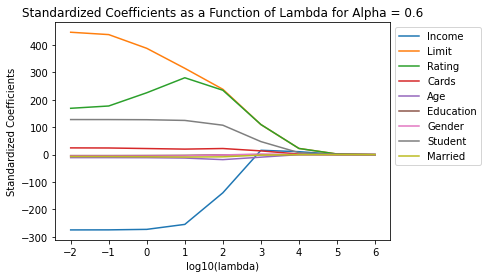

In [ ]:
features = {}
for i in range(9):
    features[i] = []

for i in range(9):
  for j in range(9):
    features[i].append(weights_a4[j][i])

for i in range(9):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0.6")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], features[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
weights_a5 = {}
alpha = 0.8
for i in range(9):
    weights_a5[i] = elastic_net(alpha, 0.01 * (10**i), X_full, y_full)

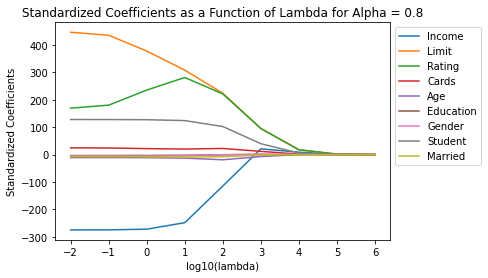

In [ ]:
features = {}
for i in range(9):
    features[i] = []

for i in range(9):
  for j in range(9):
    features[i].append(weights_a5[j][i])

for i in range(9):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0.8")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], features[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
weights_a6 = {}
alpha = 1
for i in range(9):
    weights_a6[i] = elastic_net(alpha, 0.01 * (10**i), X_full, y_full)

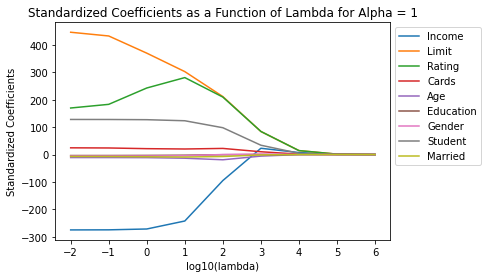

In [ ]:
features = {}
for i in range(9):
    features[i] = []

for i in range(9):
  for j in range(9):
    features[i].append(weights_a6[j][i])

for i in range(9):
  features[i] = np.array(features[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 1")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], features[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

### 5 - Fold Cross Validation Training



---



In order to find which lambda and alpha parameter pair is the most optimal for this regression model, the code below calculates the cross-validation error of each lambda and alpha parameter pair based on five-fold cross validation. The graph and output show that the best lambda and alpha parameter pair is 1000, 0/5.

In [ ]:
alpha = 0
k_fold_weights_a1 = {}
for i in range(5):
  k_fold_weights_a1[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      k_fold_weights_a1[i][j] = elastic_net(alpha, 0.01 * (10**j), X_train[i], y_train[i])

alpha = 0.2
k_fold_weights_a2 = {}
for i in range(5):
  k_fold_weights_a2[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      k_fold_weights_a2[i][j] = elastic_net(alpha, 0.01 * (10**j), X_train[i], y_train[i])

alpha = 0.4
k_fold_weights_a3 = {}
for i in range(5):
  k_fold_weights_a3[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      k_fold_weights_a3[i][j] = elastic_net(alpha, 0.01 * (10**j), X_train[i], y_train[i])

alpha = 0.6
k_fold_weights_a4 = {}
for i in range(5):
  k_fold_weights_a4[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      k_fold_weights_a4[i][j] = elastic_net(alpha, 0.01 * (10**j), X_train[i], y_train[i])

alpha = 0.8
k_fold_weights_a5 = {}
for i in range(5):
  k_fold_weights_a5[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      k_fold_weights_a5[i][j] = elastic_net(alpha, 0.01 * (10**j), X_train[i], y_train[i])

alpha = 1
k_fold_weights_a6 = {}
for i in range(5):
  k_fold_weights_a6[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      k_fold_weights_a6[i][j] = elastic_net(alpha, 0.01 * (10**j), X_train[i], y_train[i])

In [ ]:
predictions_a1 = {}
MSE_a1 = {}

predictions_a2 = {}
MSE_a2 = {}

predictions_a3 = {}
MSE_a3 = {}

predictions_a4 = {}
MSE_a4 = {}

predictions_a5 = {}
MSE_a5 = {}

predictions_a6 = {}
MSE_a6 = {}

for i in range(5):
  predictions_a1[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a1[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a2[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a2[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a3[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a3[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a4[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a4[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a5[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a5[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a6[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a6[i] = [0,0,0,0,0,0,0,0,0]

for i in range(5):
  for j in range(9):
    predictions_a1[i][j] = np.dot(X_val[i],k_fold_weights_a1[i][j])
    difference = y_val[i] - predictions_a1[i][j]
    difference = difference * difference
    sum = 0
    for x in difference:
      sum = sum + x
    MSE_a1[i][j] = sum/80

for i in range(5):
  for j in range(9):
    predictions_a2[i][j] = np.dot(X_val[i],k_fold_weights_a2[i][j])
    difference = y_val[i] - predictions_a2[i][j]
    difference = difference * difference
    sum = 0
    for x in difference:
      sum = sum + x
    MSE_a2[i][j] = sum/80

for i in range(5):
  for j in range(9):
    predictions_a3[i][j] = np.dot(X_val[i],k_fold_weights_a3[i][j])
    difference = y_val[i] - predictions_a3[i][j]
    difference = difference * difference
    sum = 0
    for x in difference:
      sum = sum + x
    MSE_a3[i][j] = sum/80

for i in range(5):
  for j in range(9):
    predictions_a4[i][j] = np.dot(X_val[i],k_fold_weights_a4[i][j])
    difference = y_val[i] - predictions_a4[i][j]
    difference = difference * difference
    sum = 0
    for x in difference:
      sum = sum + x
    MSE_a4[i][j] = sum/80

for i in range(5):
  for j in range(9):
    predictions_a5[i][j] = np.dot(X_val[i],k_fold_weights_a5[i][j])
    difference = y_val[i] - predictions_a5[i][j]
    difference = difference * difference
    sum = 0
    for x in difference:
      sum = sum + x
    MSE_a5[i][j] = sum/80

for i in range(5):
  for j in range(9):
    predictions_a6[i][j] = np.dot(X_val[i],k_fold_weights_a6[i][j])
    difference = y_val[i] - predictions_a6[i][j]
    difference = difference * difference
    sum = 0
    for x in difference:
      sum = sum + x
    MSE_a6[i][j] = sum/80

CV_a1 = {}
for i in range(9):
  CV_a1[i] = (MSE_a1[0][i] + MSE_a1[1][i] + MSE_a1[2][i] + MSE_a1[3][i] + MSE_a1[4][i])/5

CV_a2 = {}
for i in range(9):
  CV_a2[i] = (MSE_a2[0][i] + MSE_a2[1][i] + MSE_a2[2][i] + MSE_a2[3][i] + MSE_a2[4][i])/5

CV_a3 = {}
for i in range(9):
  CV_a3[i] = (MSE_a3[0][i] + MSE_a3[1][i] + MSE_a3[2][i] + MSE_a3[3][i] + MSE_a3[4][i])/5

CV_a4 = {}
for i in range(9):
  CV_a4[i] = (MSE_a4[0][i] + MSE_a4[1][i] + MSE_a4[2][i] + MSE_a4[3][i] + MSE_a4[4][i])/5

CV_a5 = {}
for i in range(9):
  CV_a5[i] = (MSE_a5[0][i] + MSE_a5[1][i] + MSE_a5[2][i] + MSE_a5[3][i] + MSE_a5[4][i])/5

CV_a6 = {}
for i in range(9):
  CV_a6[i] = (MSE_a6[0][i] + MSE_a6[1][i] + MSE_a6[2][i] + MSE_a6[3][i] + MSE_a6[4][i])/5

+----------------+--------------------+
| Lambda / Alpha |      CV Error      |
+----------------+--------------------+
| 10^-2 / (0/5)  | 10090.760712487729 |
| 10^-2 / (1/5)  | 10090.512511802863 |
| 10^-2 / (2/5)  | 10090.267375266396 |
| 10^-2 / (3/5)  | 10090.025263926718 |
| 10^-2 / (4/5)  | 10089.786139412152 |
| 10^-2 / (5/5)  | 10089.549963921407 |
| 10^-1 / (0/5)  | 10090.753322768422 |
| 10^-1 / (1/5)  | 10088.404757733673 |
| 10^-1 / (2/5)  | 10086.329974737668 |
| 10^-1 / (3/5)  | 10084.497003495368 |
| 10^-1 / (4/5)  | 10082.878208995458 |
| 10^-1 / (5/5)  | 10081.449645445009 |
|  10^0 / (0/5)  | 10090.679467097561 |
|  10^0 / (1/5)  | 10076.45394712082  |
|  10^0 / (2/5)  | 10073.24328372905  |
|  10^0 / (3/5)  | 10074.38669208892  |
|  10^0 / (4/5)  | 10077.699256569322 |
|  10^0 / (5/5)  | 10082.32396646551  |
|  10^1 / (0/5)  | 10089.94506261923  |
|  10^1 / (1/5)  | 10116.699644423179 |
|  10^1 / (2/5)  | 10228.340982063248 |
|  10^1 / (3/5)  | 10390.189452520444 |


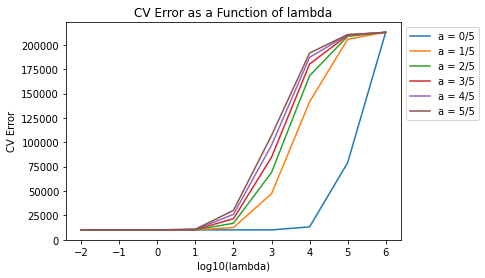

In [ ]:
x = PrettyTable()
x.field_names = ["Lambda / Alpha", "CV Error"]

cross_validation_a1 = []
cross_validation_a2 = []
cross_validation_a3 = []
cross_validation_a4 = []
cross_validation_a5 = []
cross_validation_a6 = []

for i in range(9):
  cross_validation_a1.append(CV_a1[i])
  cross_validation_a2.append(CV_a2[i])
  cross_validation_a3.append(CV_a3[i])
  cross_validation_a4.append(CV_a4[i])
  cross_validation_a5.append(CV_a5[i])
  cross_validation_a6.append(CV_a6[i])
  x.add_row(["10^" + str(i-2) + " / (0/5)", str(CV_a1[i][0])])
  x.add_row(["10^" + str(i-2) + " / (1/5)", str(CV_a2[i][0])])
  x.add_row(["10^" + str(i-2) + " / (2/5)", str(CV_a3[i][0])])
  x.add_row(["10^" + str(i-2) + " / (3/5)", str(CV_a4[i][0])])
  x.add_row(["10^" + str(i-2) + " / (4/5)", str(CV_a5[i][0])])
  x.add_row(["10^" + str(i-2) + " / (5/5)", str(CV_a6[i][0])])

print(x)
print("")
print("The value of lambda / alpha that generated the smallest CV error is 1000, 0/5")
print("")

plt.title("CV Error as a Function of lambda")
plt.xlabel("log10(lambda)")
plt.ylabel("CV Error")
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], cross_validation_a1, label = "a = 0/5")
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], cross_validation_a2, label = "a = 1/5")
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], cross_validation_a3, label = "a = 2/5")
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], cross_validation_a4, label = "a = 3/5")
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], cross_validation_a5, label = "a = 4/5")
plt.plot([-2, -1, 0, 1, 2, 3, 4, 5, 6], cross_validation_a6, label = "a = 5/5")
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

### Final Best Fit Model Parameters



---



The code below trains the elastic net regression model on the entire dataset and prints the best-fit model parameters. The value for the lambda and alpha parameter pair was based on the results we got from the five-fold cross validation. The best parameters for lasso and ridge regression are also used to obtain the best fit model parameters for lasso and ridge regression.

In [ ]:
final_weights = elastic_net((0/5), 1000, X_full, y_full)

print("Best fit model parameters")
print("-------------------------")
print("")
print(final_weights)

Best fit model parameters
-------------------------

[[-268.88922196]
 [ 434.8913347 ]
 [ 174.61378182]
 [  23.31585725]
 [  -9.92596918]
 [  -2.25892371]
 [  -3.80929035]
 [ 126.54323853]
 [  -2.09466877]]


*The best model happens to be a lasso regression model, so the cell above and below is the same.*

In [ ]:
final_weights = elastic_net((0/5), 1000, X_full, y_full)

print("Best fit model parameters for lasso regression (a=0)")
print("-------------------------")
print("")
print(final_weights)

Best fit model parameters for lasso regression (a=0)
-------------------------

[[-268.88922196]
 [ 434.8913347 ]
 [ 174.61378182]
 [  23.31585725]
 [  -9.92596918]
 [  -2.25892371]
 [  -3.80929035]
 [ 126.54323853]
 [  -2.09466877]]


In [ ]:
final_weights = elastic_net((5/5), 0.1, X_full, y_full)

print("Best fit model parameters for ridge regression (a=1)")
print("-------------------------")
print("")
print(final_weights)

Best fit model parameters for ridge regression (a=1)
-------------------------

[[-274.30915822]
 [ 432.14524481]
 [ 182.98773075]
 [  24.00739584]
 [ -10.97361905]
 [  -3.40877961]
 [  -5.19010905]
 [ 127.82225992]
 [  -7.20384668]]


The best model had the same parameter pair as the best lasso model. The best ridge regression model had a cross validation score that was around 10 units worse than the best model. However, the model parameters obtained were very similar, with most of the parameters being only a few units apart. However, it is notable that the weights for the rating and married features had a greater difference than the other parameters between the lasso and ridge regression models. It is also interesting to note that the best model was lasso rather than an intermediate combination of lasso and ridge regression. Intermediate combinations did perform better than ridge regression for several different parameter pairs, but lasso performed the best.

## Regression using Sklearn
---

The procedure that was followed for the regression from scratch will be replicated below using Sklearn's elastic net model. This will provide a comparison of the performance of a home-made model vs a machine learning library's model.

### Full Dataset Training


---



The code below trains an elastic net model from Sklearn using the full dataset across nine different lambda parameters and six different alpha values. The weights for the model are then graphed against the lambda values for each alpha value. The resulting plots looks very similar to the ones produced by the scratch-built elastic net model.

One notable difference is that the Sklearn model appears to have slightly different parameter ranges than the scratch-built model. The lambda values for the Sklearn model vary from 0.00001-1000 rather than 0.01-1000000 as it was in the scratch-built model. The alpha values are also reversed with 0 being ridge and 1 being lasso rather than 1 being ridge and 0 being lasso as it was in the scratch-built model.

In [ ]:
sklearn_weights_a1 = {}
alpha = 0
for i in range(9):
    clf = ElasticNet(alpha = 0.00001 * (10**i), l1_ratio = alpha)
    clf.fit(X_full, y_full)
    ElasticNet()
    sklearn_weights_a1[i] = np.array(clf.coef_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e+06, tolerance: 8.434e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e+06, tolerance: 8.434e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

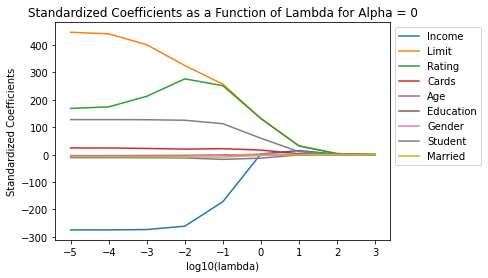

In [ ]:
sklearn_features_a1 = {}
for i in range(9):
    sklearn_features_a1[i] = []

for i in range(9):
  for j in range(9):
    sklearn_features_a1[i].append(sklearn_weights_a1[j][i])

for i in range(9):
  sklearn_features_a1[i] = np.array(sklearn_features_a1[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], sklearn_features_a1[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
sklearn_weights_a2 = {}
alpha = 0.2
for i in range(9):
    clf = ElasticNet(alpha = 0.00001 * (10**i), l1_ratio = alpha)
    clf.fit(X_full, y_full)
    ElasticNet()
    sklearn_weights_a2[i] = np.array(clf.coef_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

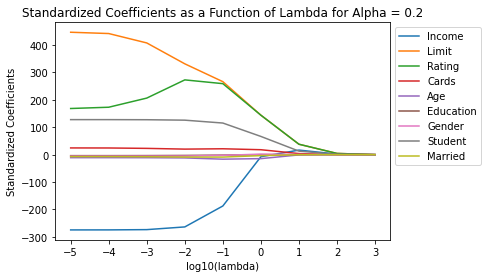

In [ ]:
sklearn_features_a2 = {}
for i in range(9):
    sklearn_features_a2[i] = []

for i in range(9):
  for j in range(9):
    sklearn_features_a2[i].append(sklearn_weights_a2[j][i])

for i in range(9):
  sklearn_features_a2[i] = np.array(sklearn_features_a2[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0.2")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], sklearn_features_a2[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
sklearn_weights_a3 = {}
alpha = 0.4
for i in range(9):
    clf = ElasticNet(alpha = 0.00001 * (10**i), l1_ratio = alpha)
    clf.fit(X_full, y_full)
    ElasticNet()
    sklearn_weights_a3[i] = np.array(clf.coef_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

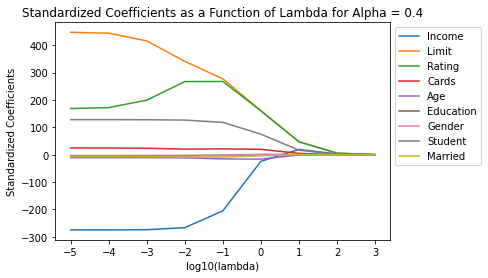

In [ ]:
sklearn_features_a3 = {}
for i in range(9):
    sklearn_features_a3[i] = []

for i in range(9):
  for j in range(9):
    sklearn_features_a3[i].append(sklearn_weights_a3[j][i])

for i in range(9):
  sklearn_features_a3[i] = np.array(sklearn_features_a3[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0.4")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], sklearn_features_a3[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
sklearn_weights_a4 = {}
alpha = 0.6
for i in range(9):
    clf = ElasticNet(alpha = 0.00001 * (10**i), l1_ratio = alpha)
    clf.fit(X_full, y_full)
    ElasticNet()
    sklearn_weights_a4[i] = np.array(clf.coef_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

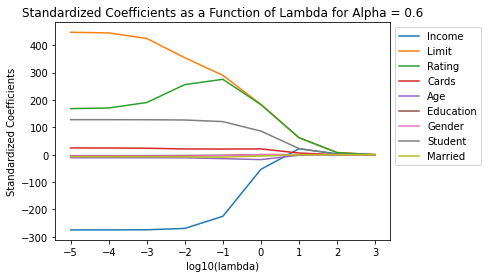

In [ ]:
sklearn_features_a4 = {}
for i in range(9):
    sklearn_features_a4[i] = []

for i in range(9):
  for j in range(9):
    sklearn_features_a4[i].append(sklearn_weights_a4[j][i])

for i in range(9):
  sklearn_features_a4[i] = np.array(sklearn_features_a4[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0.6")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], sklearn_features_a4[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
sklearn_weights_a5 = {}
alpha = 0.8
for i in range(9):
    clf = ElasticNet(alpha = 0.00001 * (10**i), l1_ratio = alpha)
    clf.fit(X_full, y_full)
    ElasticNet()
    sklearn_weights_a5[i] = np.array(clf.coef_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

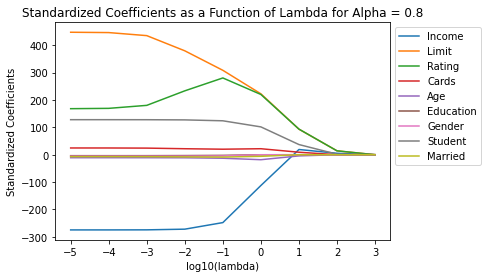

In [ ]:
sklearn_features_a5 = {}
for i in range(9):
    sklearn_features_a5[i] = []

for i in range(9):
  for j in range(9):
    sklearn_features_a5[i].append(sklearn_weights_a5[j][i])

for i in range(9):
  sklearn_features_a5[i] = np.array(sklearn_features_a5[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 0.8")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], sklearn_features_a5[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

In [ ]:
sklearn_weights_a6 = {}
alpha = 1
for i in range(9):
    clf = ElasticNet(alpha = 0.00001 * (10**i), l1_ratio = alpha)
    clf.fit(X_full, y_full)
    ElasticNet()
    sklearn_weights_a6[i] = np.array(clf.coef_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e+06, tolerance: 8.434e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

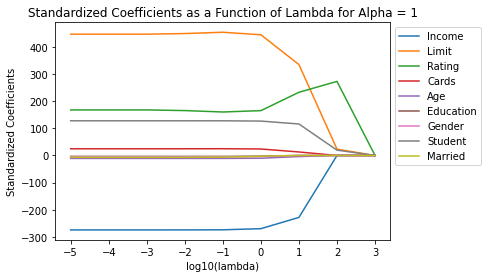

In [ ]:
sklearn_features_a6 = {}
for i in range(9):
    sklearn_features_a6[i] = []

for i in range(9):
  for j in range(9):
    sklearn_features_a6[i].append(sklearn_weights_a6[j][i])

for i in range(9):
  sklearn_features_a6[i] = np.array(sklearn_features_a6[i])

feature_names = {}
feature_names[0] = "Income"
feature_names[1] = "Limit"
feature_names[2] = "Rating"
feature_names[3] = "Cards"
feature_names[4] = "Age"
feature_names[5] = "Education"
feature_names[6] = "Gender"
feature_names[7] = "Student"
feature_names[8] = "Married"

plt.title("Standardized Coefficients as a Function of Lambda for Alpha = 1")
plt.xlabel("log10(lambda)")
plt.ylabel("Standardized Coefficients")
for i in range(9):
  plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], sklearn_features_a6[i], label=feature_names[i])
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

### 5 - Fold Cross Validation Training


---



Five fold cross validation is performed to identify the best lambda-alpha parameter pair for the Sklearn model. After printing and graphing the cross validation errors, it can be seen that 1,1 is the best lambda-alpha value pair for the model. This was the same parameter pair that we obtained for the scratch-built model after considering the shift in parameter domains. This value suggests that a lasso model is best suited for the regression task. The graph also demonstrates the same trends in CV error as the original model. One notable difference is that the Sklearn model achieves a CV error that is a few units lower than the best scratch-built model.

In [ ]:
predictions_a1 = {}
MSE_a1 = {}

predictions_a2 = {}
MSE_a2 = {}

predictions_a3 = {}
MSE_a3 = {}

predictions_a4 = {}
MSE_a4 = {}

predictions_a5 = {}
MSE_a5 = {}

predictions_a6 = {}
MSE_a6 = {}

for i in range(5):
  predictions_a1[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a1[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a2[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a2[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a3[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a3[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a4[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a4[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a5[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a5[i] = [0,0,0,0,0,0,0,0,0]

  predictions_a6[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
  MSE_a6[i] = [0,0,0,0,0,0,0,0,0]

alpha = 0
k_fold_weights_a1 = {}
for i in range(5):
  k_fold_weights_a1[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      clf = ElasticNet(alpha = 0.00001 * (10**j), l1_ratio = alpha)
      clf.fit(X_train[i], y_train[i])
      ElasticNet()
      k_fold_weights_a1[i][j] = np.array(clf.coef_)
      predictions_a1[i][j] = clf.predict(X_val[i])
      MSE_a1[i][j] = mean_squared_error(y_val[i], predictions_a1[i][j])

alpha = 0.2
k_fold_weights_a2 = {}
for i in range(5):
  k_fold_weights_a2[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      clf = ElasticNet(alpha = 0.00001 * (10**j), l1_ratio = alpha)
      clf.fit(X_train[i], y_train[i])
      ElasticNet()
      k_fold_weights_a2[i][j] = np.array(clf.coef_)
      predictions_a2[i][j] = clf.predict(X_val[i])
      MSE_a2[i][j] = mean_squared_error(y_val[i], predictions_a2[i][j])

alpha = 0.4
k_fold_weights_a3 = {}
for i in range(5):
  k_fold_weights_a3[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      clf = ElasticNet(alpha = 0.00001 * (10**j), l1_ratio = alpha)
      clf.fit(X_train[i], y_train[i])
      ElasticNet()
      k_fold_weights_a3[i][j] = np.array(clf.coef_)
      predictions_a3[i][j] = clf.predict(X_val[i])
      MSE_a3[i][j] = mean_squared_error(y_val[i], predictions_a3[i][j])

alpha = 0.6
k_fold_weights_a4 = {}
for i in range(5):
  k_fold_weights_a4[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      clf = ElasticNet(alpha = 0.00001 * (10**j), l1_ratio = alpha)
      clf.fit(X_train[i], y_train[i])
      ElasticNet()
      k_fold_weights_a4[i][j] = np.array(clf.coef_)
      predictions_a4[i][j] = clf.predict(X_val[i])
      MSE_a4[i][j] = mean_squared_error(y_val[i], predictions_a4[i][j])

alpha = 0.8
k_fold_weights_a5 = {}
for i in range(5):
  k_fold_weights_a5[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      clf = ElasticNet(alpha = 0.00001 * (10**j), l1_ratio = alpha)
      clf.fit(X_train[i], y_train[i])
      ElasticNet()
      k_fold_weights_a5[i][j] = np.array(clf.coef_)
      predictions_a5[i][j] = clf.predict(X_val[i])
      MSE_a5[i][j] = mean_squared_error(y_val[i], predictions_a5[i][j])

alpha = 1
k_fold_weights_a6 = {}
for i in range(5):
  k_fold_weights_a6[i] = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]

for i in range(5):
  for j in range(9):
      clf = ElasticNet(alpha = 0.00001 * (10**j), l1_ratio = alpha)
      clf.fit(X_train[i], y_train[i])
      ElasticNet()
      k_fold_weights_a6[i][j] = np.array(clf.coef_)
      predictions_a6[i][j] = clf.predict(X_val[i])
      MSE_a6[i][j] = mean_squared_error(y_val[i], predictions_a6[i][j])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e+06, tolerance: 6.885e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+06, tolerance: 6.885e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

In [ ]:
CV_a1 = {}
for i in range(9):
  CV_a1[i] = (MSE_a1[0][i] + MSE_a1[1][i] + MSE_a1[2][i] + MSE_a1[3][i] + MSE_a1[4][i])/5

CV_a2 = {}
for i in range(9):
  CV_a2[i] = (MSE_a2[0][i] + MSE_a2[1][i] + MSE_a2[2][i] + MSE_a2[3][i] + MSE_a2[4][i])/5

CV_a3 = {}
for i in range(9):
  CV_a3[i] = (MSE_a3[0][i] + MSE_a3[1][i] + MSE_a3[2][i] + MSE_a3[3][i] + MSE_a3[4][i])/5

CV_a4 = {}
for i in range(9):
  CV_a4[i] = (MSE_a4[0][i] + MSE_a4[1][i] + MSE_a4[2][i] + MSE_a4[3][i] + MSE_a4[4][i])/5

CV_a5 = {}
for i in range(9):
  CV_a5[i] = (MSE_a5[0][i] + MSE_a5[1][i] + MSE_a5[2][i] + MSE_a5[3][i] + MSE_a5[4][i])/5

CV_a6 = {}
for i in range(9):
  CV_a6[i] = (MSE_a6[0][i] + MSE_a6[1][i] + MSE_a6[2][i] + MSE_a6[3][i] + MSE_a6[4][i])/5

+----------------+--------------------+
| Lambda / Alpha |      CV Error      |
+----------------+--------------------+
| 10^-5 / (0/5)  | 10090.36561600832  |
| 10^-5 / (1/5)  | 10090.444065295827 |
| 10^-5 / (2/5)  | 10090.522827171928 |
| 10^-5 / (3/5)  | 10090.601902920054 |
| 10^-5 / (4/5)  | 10090.681293829915 |
| 10^-5 / (5/5)  | 10090.761001197356 |
| 10^-4 / (0/5)  | 10087.134640274146 |
| 10^-4 / (1/5)  | 10087.80264711396  |
| 10^-4 / (2/5)  | 10088.49768173876  |
| 10^-4 / (3/5)  | 10089.220848969426 |
| 10^-4 / (4/5)  | 10089.973307273534 |
| 10^-4 / (5/5)  | 10090.75627167254  |
| 10^-3 / (0/5)  | 10073.841082315119 |
| 10^-3 / (1/5)  | 10074.920806319906 |
| 10^-3 / (2/5)  | 10076.77755878046  |
| 10^-3 / (3/5)  | 10079.699198160106 |
| 10^-3 / (4/5)  | 10084.119624148716 |
| 10^-3 / (5/5)  | 10090.708993431997 |
| 10^-2 / (0/5)  | 10177.278013552492 |
| 10^-2 / (1/5)  | 10142.375931317347 |
| 10^-2 / (2/5)  | 10112.940071554565 |
| 10^-2 / (3/5)  | 10089.312823618642 |


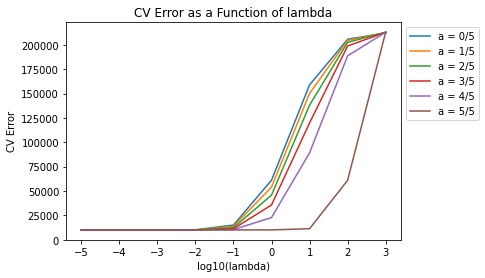

In [ ]:
x = PrettyTable()
x.field_names = ["Lambda / Alpha", "CV Error"]

cross_validation_a1 = []
cross_validation_a2 = []
cross_validation_a3 = []
cross_validation_a4 = []
cross_validation_a5 = []
cross_validation_a6 = []

for i in range(9):
  cross_validation_a1.append(CV_a1[i])
  cross_validation_a2.append(CV_a2[i])
  cross_validation_a3.append(CV_a3[i])
  cross_validation_a4.append(CV_a4[i])
  cross_validation_a5.append(CV_a5[i])
  cross_validation_a6.append(CV_a6[i])
  x.add_row(["10^" + str(i-5) + " / (0/5)", str(CV_a1[i])])
  x.add_row(["10^" + str(i-5) + " / (1/5)", str(CV_a2[i])])
  x.add_row(["10^" + str(i-5) + " / (2/5)", str(CV_a3[i])])
  x.add_row(["10^" + str(i-5) + " / (3/5)", str(CV_a4[i])])
  x.add_row(["10^" + str(i-5) + " / (4/5)", str(CV_a5[i])])
  x.add_row(["10^" + str(i-5) + " / (5/5)", str(CV_a6[i])])

print(x)
print("")
print("The value of lambda / alpha that generated the smallest CV error is 1, 5/5")
print("")

plt.title("CV Error as a Function of lambda")
plt.xlabel("log10(lambda)")
plt.ylabel("CV Error")
plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], cross_validation_a1, label = "a = 0/5")
plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], cross_validation_a2, label = "a = 1/5")
plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], cross_validation_a3, label = "a = 2/5")
plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], cross_validation_a4, label = "a = 3/5")
plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], cross_validation_a5, label = "a = 4/5")
plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3], cross_validation_a6, label = "a = 5/5")
plt.legend(loc='best', bbox_to_anchor=(1,1))
print("")

### Final Best Fit Model Parameters


---



Finally, the Sklearn elastic net algorithm is trained using the full dataset and the best lambda-alpha parameter pair from the five-fold cross validation. The model parameters are printed below. They are within a few units of the best fit model parameters output by the original elastic net model. The best lasso and ridge regression models are also trained and output.

In [ ]:
clf = ElasticNet(alpha = 1, l1_ratio = 1)
clf.fit(X_full, y_full)
ElasticNet()
sklearn_final_weights = np.array(clf.coef_)

print("Best fit model parameters")
print("-------------------------")
print("")
print(sklearn_final_weights)

Best fit model parameters
-------------------------

[-270.05835467  445.2955794   165.41464689   23.91951822  -10.11639686
   -2.54657822   -4.08783151  126.8737829    -2.96218581]


*The best model happens to be a lasso regression model, so the cell above and below is the same.*

In [ ]:
clf = ElasticNet(alpha = 1, l1_ratio = 1)
clf.fit(X_full, y_full)
ElasticNet()
sklearn_final_weights = np.array(clf.coef_)

print("Best lasso model parameters (a=1)")
print("-------------------------")
print("")
print(sklearn_final_weights)

Best lasso model parameters (a=1)
-------------------------

[-270.05835467  445.2955794   165.41464689   23.91951822  -10.11639686
   -2.54657822   -4.08783151  126.8737829    -2.96218581]


In [ ]:
clf = ElasticNet(alpha = 0.001, l1_ratio = 0)
clf.fit(X_full, y_full)
ElasticNet()
sklearn_final_weights = np.array(clf.coef_)

print("Best ridge model parameters (a=0)")
print("-------------------------")
print("")
print(sklearn_final_weights)

Best ridge model parameters (a=0)
-------------------------

[-273.29757831  401.19145676  212.96854351   22.73383936  -11.08369793
   -3.23560328   -5.15879888  127.51411517   -7.64414923]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e+06, tolerance: 8.434e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## Discussions and Conclusions

---
Overall, the results showed that an elastic net model could be created from scratch to learn the relationship between the nine input parameters and credit card balance. The cross validation from the scratch-built model showed that the lambda-alpha value pair that was optimal was 1000, 0. This indicates that the pure-lasso elastic net model performed the best. The Sklearn model had similar results and indicated the same optimal lambda-alpha value pair when it was mapped from its slightly different input parameter domain to the scratch-built model input domain. The value pair that was received for the Sklearn model was 1,1, however, the 0 and 1 for the alpha value was flipped in the Sklearn model and the range of lambda values was 0.00001-1000 rather than 0.01-1000000. Thus, after taking this into account, the same optimal values are obtained. It is notable that the model hyper-parameters were shifted between the scratch-built implementation and the Sklearn implementation. The graphs, CV errors, and trained model parameters obtained were very similar, indicating that the effect of the parameters on the models was similar. Several differences between the two models could have resulted in these slight variations. The method that Sklearn uses to handle the input parameter, the number of iterations the model runs for, and the random initialization of model parameters could all have impacted the results obtained, creating the differences that were noted. Finally, the Sklearn model issued a warning upon compiling that stated that the model did not converge. This may have also indicated a difference that impacted the results of the Sklearn model. 

The figure below compares the trained parameters of the two final models. It can be seen that they are very similar to one another. The largest difference is between the parameters for the second and third features.



```
Best fit model parameters for
elastic net (lasso) from scratch
-----------------------------

[[-268.88922196]
 [ 434.8913347 ]
 [ 174.61378182]
 [  23.31585725]
 [  -9.92596918]
 [  -2.25892371]
 [  -3.80929035]
 [ 126.54323853]
 [  -2.09466877]]
```



```
Best fit model parameters for
elastic net (lasso) using Sklearn
-------------------------

[[-270.05835467]  
 [ 445.2955794 ]   
 [ 165.41464689]  
 [  23.91951822]  
 [ -10.11639686]
 [  -2.54657822]   
 [  -4.08783151]  
 [  126.8737829]    
 [  -2.96218581]]
```





Note that the comparison shown above is for a specific run of the models. Due to the stochastic nature of some of the elements involved in training the models, these parameters may slightly differ on subsequent executions.

### References

---

The sources below are links to various resources that I utilized while working on this project.

- Photo by <a href="https://unsplash.com/@hostreviews?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Stephen Phillips - Hostreviews.co.uk</a> on <a href="https://unsplash.com/s/photos/credit-card?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

> *Image credit for cover photo*

- https://scikit-learn.org/stable/

> *Scikit-learn doccumentation*

- https://numpy.org/

> *NumPy doccumentation*

- https://pandas.pydata.org/

> *pandas doccumentation*

- https://matplotlib.org/

> *Matplotlib doccumentation*

- https://pypi.org/project/prettytable/

> *PrettyTable doccumentation*